In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import k_means
import matplotlib.pyplot as plt
from ctypes import wintypes

###### Data preprocessing

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
train_df.describe().to_excel('describe.xlsx')

In [38]:
test_df.shape, train_df.shape

((200000, 201), (200000, 202))

In [287]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,segment_var_60,segment_var_80,segment_var_81,segment_var_88,segment_var_92,segment_var_94,segment_var_95,segment_var_98,segment_var_99,grouped_var_68
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,0,0,0,0,0,0,0,0,0,2
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,0,0,0,0,0,0,0,0,0,1
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,1,0,0,0,0,0,0,0,0,1
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,0,0,0,0,0,0,0,0,0,1
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,0,0,0,0,0,0,0,0,0,2


In [288]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,segment_var_60,segment_var_80,segment_var_81,segment_var_88,segment_var_92,segment_var_94,segment_var_95,segment_var_98,segment_var_99,grouped_var_68
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,1,0,0,0,0,0,0,0,0,4.0
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,0,1,0,0,0,0,0,0,0,2.0
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,0,0,0,0,0,0,0,0,0,2.0
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,0,0,0,0,0,0,0,0,0,2.0
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,1,0,0,1,0,0,0,0,0,4.0


In [57]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


<h6> Here is a part of hypothesis testing. In competition discussion, by participants who have reached score higher than ROC_AUC=0.91, were mentioned that the significant score increment depends on specific data preprocessing ("Magic feature" in discussion). <br>So we have tested our models with fixed parameters to see if there is such increment.

In [62]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [63]:
# Params were taken from public kernel
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.33,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.015,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 50,
    'num_threads': 20,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}

In [64]:
num_round = 100000
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))

In [71]:
# We stack 10 LightGbm's models 
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 2500)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))




Fold 0
Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.945726	valid_1's auc: 0.888959
[2000]	training's auc: 0.965805	valid_1's auc: 0.894139
[3000]	training's auc: 0.979331	valid_1's auc: 0.89566
[4000]	training's auc: 0.988543	valid_1's auc: 0.895696
[5000]	training's auc: 0.994336	valid_1's auc: 0.895878
[6000]	training's auc: 0.997536	valid_1's auc: 0.895661
[7000]	training's auc: 0.999082	valid_1's auc: 0.895122
Early stopping, best iteration is:
[4638]	training's auc: 0.992584	valid_1's auc: 0.896115
Fold 1
Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.945723	valid_1's auc: 0.89126
[2000]	training's auc: 0.965502	valid_1's auc: 0.896076
[3000]	training's auc: 0.97912	valid_1's auc: 0.896592
[4000]	training's auc: 0.988376	valid_1's auc: 0.896995
[5000]	training's auc: 0.994216	valid_1's auc: 0.897008
[6000]	training's auc: 0.997501	valid_1's auc: 0.8965
[7000]	training's auc: 0.99908	valid_1's auc

KeyboardInterrupt: 

In [296]:
submission = pd.DataFrame({"ID_code": test_df.ID_code.values})
submission["target"] = predictions
submission.to_csv("submission_v1.csv", index=False)

In [13]:
submission.head()

,ID_code,target
0,test_0,0.102775
1,test_1,0.216660
2,test_2,0.168685
3,test_3,0.197650
4,test_4,0.044479


###### LightGbm model trains for a while, so we tried to use simpler model - Naive Bayes. But after several tests we stopped using it, because LightGbm gives much better results than NB on the same data. So we could not make any assumtions about considered approach - does it works or just bad score because of NB, and after we used LightGbm only.

In [410]:
folds = StratifiedKFold(n_splits=3, shuffle=False, random_state=44000)

In [395]:
target_initial = train_df['target']

In [422]:
train_df['target'] = target_initial

In [423]:
train_df['target'] = train_df['target'].apply(lambda x: np.roll(x, 5))

###### Here is example of target rearranging. When we roll initial target, the result of the model does not much changed. We thought that the data is 

In [184]:
gnb = GaussianNB()
for train_index,test_index in folds.split(train_df[features],train_df['target']):
    gnb.fit(train_df.loc[train_index,features],train_df.loc[train_index,'target'])
    m = metrics.roc_auc_score(train_df.loc[test_index,'target'],
          gnb.predict_proba(train_df.loc[test_index,features])[:,1])
    print(m)

0.8895926981952564
0.8848983736599818
0.8803992577135665
0.89511118367607
0.8785337055384762
0.8868135443380749
0.8894508912215868
0.8885593908791155
0.8876252011022795
0.8957772503544178
0.8955964179861958
0.8895179800034541


### Data explonatory

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

###### Such distributions were considered for all 200 features. From this were highlighted bi-modal features, feature with few unique values

In [6]:
def an(x):
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title(x)
    
    sns.distplot(train_df[x],bins=200)
    
    plt.subplot(1,3,2)
    plt.title(x+'_target=1')
    sns.distplot(train_df[train_df['target']==1][x],bins=200)
    plt.subplot(1,3,3)
    plt.title(x+'_target=0')
    sns.distplot(train_df[train_df['target']==0][x],bins=200)
    

In [7]:
train_df['var_109'].nunique()

112172

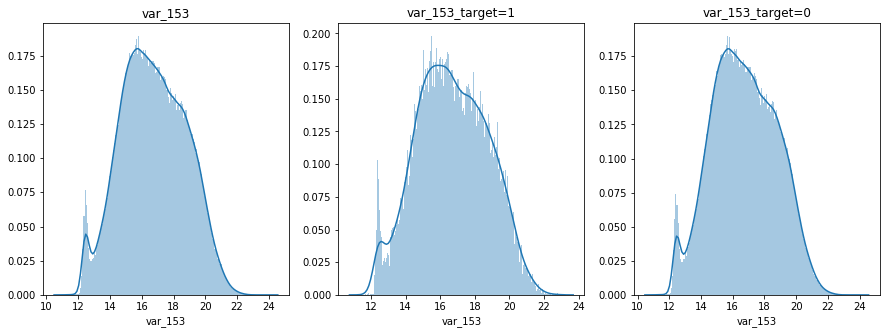

In [8]:
an('var_153')

In [164]:
def bn(x,l,r):
    sns.distplot(train_df[(train_df[x]>l)&(train_df[x]<r)][x],bins=200)

###### Example of consideration of bi-modal feature "var_153"

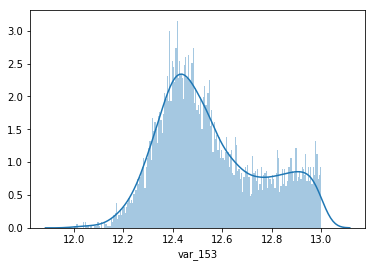

In [373]:
bn('var_153',12,13)

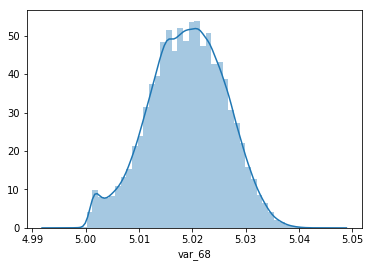

In [19]:
sns.distplot(train_df['var_68'])

In [20]:
nuq = train_df.nunique()

In [24]:
nuq.sort_values().drop('var_68_d')

target          2
var_68        451
var_91       7962
var_108      8525
var_103      9376
var_12       9561
var_148     10608
var_161     11071
var_71      13527
var_25      14853
var_43      15188
var_125     16059
var_166     17902
var_169     18242
var_133     19236
var_15      19810
var_131     21464
var_23      24913
var_34      25164
var_93      26708
var_95      29387
var_42      31592
var_50      32308
var_126     32411
var_98      33266
var_53      33460
var_57      35545
var_28      35859
var_130     36638
var_59      37744
            ...  
var_118    143667
var_19     144180
var_83     144281
var_137    144397
var_158    144556
var_54     144776
var_82     144829
var_184    145184
var_178    145235
var_30     145977
var_102    146237
var_96     148099
var_149    148504
var_182    149195
var_199    149430
var_100    150727
var_48     152039
var_70     153193
var_47     154781
var_160    156274
var_136    156615
var_187    157031
var_90     157210
var_120    158269
var_97    

In [289]:
len(suspisious_segments)

29

In [13]:
train_df['var_68'].min(),train_df['var_68'].max(),train_df['var_68'].nunique()

(4.9938, 5.0469, 451)

In [14]:
train_df['var_68_d'] = train_df['var_68']*10000 - train_df['var_68'].min() * 10000

In [16]:
train_df['var_68_d'].min(),train_df['var_68_d'].max()

(0.0, 531.0)

<h6> The segments of features that made the second mode of distribution are below. The reason of consideration is hypothesis that the data given from mixing of two distributions. 

In [9]:
suspisious_segments = {
    'var_1':[7,8.5],
    'var_2':[12,13],
    'var_4':[13.7,14.8],
    'var_5':[9,14],
    'var_9':[7.5,8],
    'var_12':[13.525,13.575],
    'var_16':[10.5,11],
    'var_21':[0,10],
    'var_26':[6,11],
    'var_29':[11,11.8],
    'var_35':[12.5,14.5],
    'var_37':[11,11.25],
    'var_40':[11,13],
    'var_41':[8.5,9.3],
    'var_43':[10.85,11],
    'var_44':[-6,-1],
    'var_50':[11.3,11.5],
    'var_53':[7.75,7.825],
    'var_55':[8,12],
    'var_59':[7.15,8],
    'var_60':[10,14],
    'var_80':[1.5,2.5],
    'var_81':[8.9,9.3],
    'var_88':[3,4],
    'var_92':[3.5,4.7],
    'var_94':[10,10.5],
    'var_95':[1.2,1.5],
    'var_98':[0,0.3],
    'var_99':[3.75,3.9],
    'var_101':[1.55,2.3],
    'var_126':[11.25,11.75],
    'var_134':[8.7,9.5],
    'var_135':[12,14],
    'var_137':[1,3.8],
    'var_141':[3.7,4.5],
    'var_145':[13,14.5],
    'var_150':[11,12.2],
    'var_152':[12.2,12.6]
}

In [10]:
len(suspisious_segments)

38

###### Var_68 - categorical variable

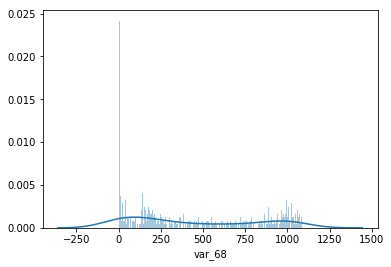

In [195]:

sns.distplot(train_df['var_68'].value_counts(),bins=200)

###### Attempt to group 451 value in 5 groups

In [212]:
clustered_categories = k_means(np.reshape(train_df['var_68'].value_counts().values,(451,1)),
                 n_clusters=5)[1]

In [213]:
clustered_categories_dict = dict(zip(train_df['var_68'].value_counts().index,clustered_categories))

###### Creation of indicator features if the value in bi-modal interval

In [274]:
train_df['var_1'].map(lambda x: 1 if x >=suspisious_segments['var_1'][0]
                                 and x <=suspisious_segments['var_1'][1] else 0).value_counts()

0    196970
1      3030
Name: var_1, dtype: int64

In [275]:
for col in suspisious_segments:
    train_df['segment_'+col] = train_df[col].map(lambda x: 1 if x >=suspisious_segments[col][0]
                                 and x <=suspisious_segments[col][1] else 0)

In [283]:
train_df['grouped_var_68'] = train_df['var_68'].map(clustered_categories_dict)

In [285]:
for col in suspisious_segments:
    test_df['segment_'+col] = test_df[col].map(lambda x: 1 if x >=suspisious_segments[col][0]
                                 and x <=suspisious_segments[col][1] else 0)

In [286]:
test_df['grouped_var_68'] = test_df['var_68'].map(clustered_categories_dict)

In [379]:
train_df['target'].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

In [380]:
for col in train_df.columns:
    print(col,train_df[col].nunique())

ID_code 200000
target 2
var_0 94672
var_1 108932
var_2 86555
var_3 74597
var_4 63515
var_5 141029
var_6 38599
var_7 103063
var_8 98617
var_9 49417
var_10 128764
var_11 130193
var_12 9561
var_13 115181
var_14 79122
var_15 19810
var_16 86918
var_17 137823
var_18 139515
var_19 144180
var_20 127764
var_21 140062
var_22 90660
var_23 24913
var_24 105101
var_25 14853
var_26 127089
var_27 60185
var_28 35859
var_29 88339
var_30 145977
var_31 77388
var_32 85964
var_33 112239
var_34 25164
var_35 122384
var_36 96404
var_37 79040
var_38 115366
var_39 112674
var_40 141878
var_41 131896
var_42 31592
var_43 15188
var_44 127702
var_45 169968
var_46 93450
var_47 154781
var_48 152039
var_49 140641
var_50 32308
var_51 143455
var_52 121313
var_53 33460
var_54 144776
var_55 128077
var_56 103045
var_57 35545
var_58 113907
var_59 37744
var_60 113763
var_61 159369
var_62 74777
var_63 97098
var_64 59379
var_65 108347
var_66 47722
var_67 137253
var_68 451
var_69 110346
var_70 153193
var_71 13527
var_72 110114
va

###### Target distribution over categories

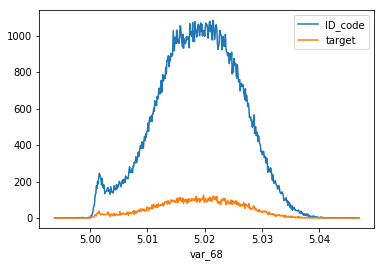

In [387]:
train_df.groupby('var_68').agg({'target':'sum','ID_code':'nunique'}).reset_index().plot(x='var_68',y=['ID_code','target'])

In [456]:
unique_nums = train_df.nunique()

<h6> After consideration of differences between categories we made assumption that there is a timeseries variable. So we tried decode it and create features

In [473]:
# differences in most cases are the same
train_df['var_68'].sort_values().unique() - np.append(train_df['var_68'].sort_values().unique()[1:],0)

array([-1.3000e-03, -1.3000e-03, -3.0000e-04, -9.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -3.0000e-04, -1.0000e-04,
       -1.0000e-04, -3.0000e-04, -1.0000e-04, -1.0000e-04, -2.0000e-04,
       -1.0000e-04, -2.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04,
       -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.0000e-04, -1.00

In [476]:
train_df['var_68'].sort_values().unique()/0.0001

array([49938., 49951., 49964., 49967., 49976., 49977., 49978., 49979.,
       49980., 49983., 49984., 49985., 49988., 49989., 49990., 49992.,
       49993., 49995., 49996., 49997., 49998., 49999., 50000., 50001.,
       50002., 50003., 50004., 50005., 50006., 50007., 50008., 50009.,
       50010., 50011., 50012., 50013., 50014., 50015., 50016., 50017.,
       50018., 50019., 50020., 50021., 50022., 50023., 50024., 50025.,
       50026., 50027., 50028., 50029., 50030., 50031., 50032., 50033.,
       50034., 50035., 50036., 50037., 50038., 50039., 50040., 50041.,
       50042., 50043., 50044., 50045., 50046., 50047., 50048., 50049.,
       50050., 50051., 50052., 50053., 50054., 50055., 50056., 50057.,
       50058., 50059., 50060., 50061., 50062., 50063., 50064., 50065.,
       50066., 50067., 50068., 50069., 50070., 50071., 50072., 50073.,
       50074., 50075., 50076., 50077., 50078., 50079., 50080., 50081.,
       50082., 50083., 50084., 50085., 50086., 50087., 50088., 50089.,
      

In [480]:
cr_matrix = train_df.corr()

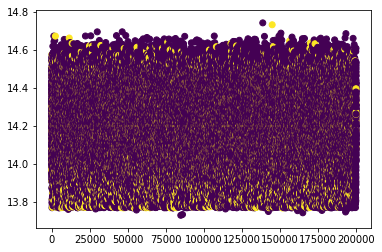

In [496]:
plt.scatter(range(len(train_df)),train_df['var_68'],c=train_df['target'])

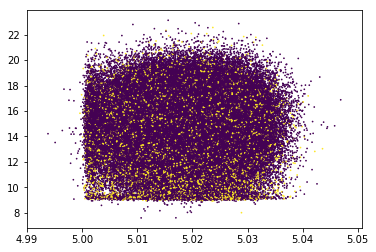

In [518]:
plt.scatter(train_df['var_68'],train_df['var_81'],c=train_df['target'],s=0.5)

In [4]:
cols = train_df.columns[range(2,202)]

In [5]:
cols

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_9',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=200)

In [1]:
for i in ['var_68','var_12','var_23','var_25','var_43','var_91','var_103','var_108','var_161','var_166','var_169']:
    for j in list(range(0,200)):
        plt.figure(figsize=(10,8))
        plt.xlabel(i)
        plt.ylabel(cols[j])
        plt.scatter(train_df[i],train_df[cols[j]],c=train_df['target'],s=0.5)
        plt.savefig('pictures/'+i+'_'+cols[j]+'.png')

###### We have considered pair-plots of features(that had the largest feature importance in LightGbm) in order to find some dependencies. But all they look's like random bubbles.

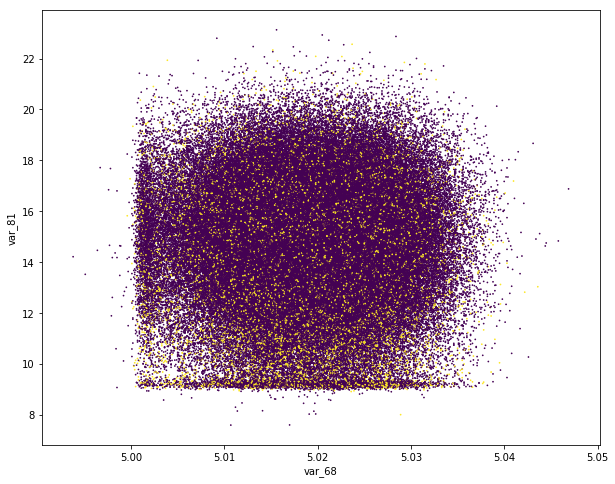

In [536]:
plt.figure(figsize=(10,8))
plt.xlabel('var_68')
plt.ylabel('var_81')
plt.scatter(train_df['var_68'],train_df['var_81'],c=train_df['target'],s=0.5)
plt.savefig('abc.png')

In [4]:
def abc(a,b):    
    plt.figure(figsize=(10,8))
    plt.xlabel(a)
    plt.ylabel(b)
    plt.scatter(train_df[a],train_df[b],c=train_df['target'],s=0.5)


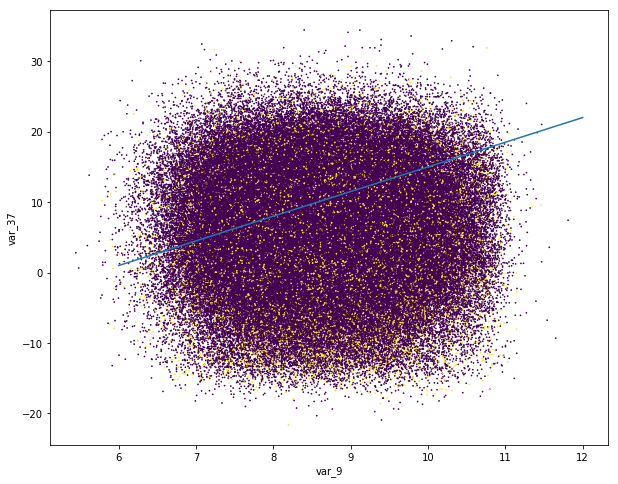

In [35]:
# example of feature generation
plt.figure(figsize=(10,8))
plt.xlabel('var_9')
plt.ylabel('var_37')
plt.plot([x for x in range(6,13)],[-20 + 3.5 * x for x in range(6,13)])
plt.scatter(train_df['var_144'],train_df['var_76'],c=train_df['target'],s=0.5)

<h6> We tried to fit features into ARIMA in order to see if there is time series (did it row-wise and column-wise). But it didn't work. The motivation is that in previous Santander competition were time series both row- and colums-wise.

In [53]:

from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy


model = ARIMA(train_df.groupby('var_68').agg({'target':sum}), order=(2,0,2))
model_fit = model.fit(disp=0)
#

C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [54]:
 
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:                 target   No. Observations:                  451
Model:                     ARMA(2, 2)   Log Likelihood               -1536.437
Method:                       css-mle   S.D. of innovations              7.269
Date:                Thu, 21 Mar 2019   AIC                           3084.874
Time:                        23:50:20   BIC                           3109.543
Sample:                             0   HQIC                          3094.596
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           14.4534     30.376      0.476      0.634     -45.083      73.990
ar.L1.target     0.2428      0.137      1.776      0.076      -0.025       0.511
ar.L2.target     0.7535      0.136      5.52

In [7]:
unique_axis_1 = train_df.nunique(axis=1)

In [9]:
unique_axis_1.value_counts()

202    187025
201     12561
200       411
199         3
dtype: int64

In [11]:
train_df.sort_values(by='var_68',inplace=True)

In [45]:

from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
import numpy

In [13]:
cols = train_df.columns[2:]

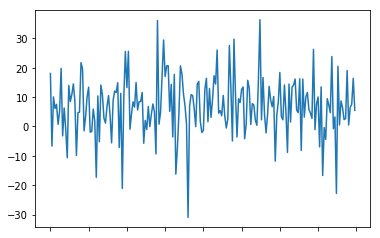

In [46]:
train_df.iloc[3,2:].plot()

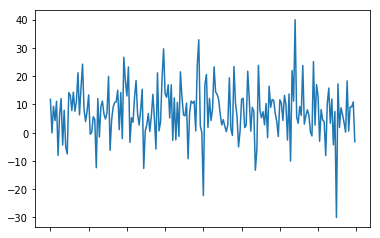

In [47]:
train_df.loc[6,cols].plot()

In [102]:
aic = 5000
params = []
for p in [0,1,2,3]:
    for d in [0,1]:
        for q in [0,1,2,3]:
            try:
                model = ARIMA(train_df.iloc[5,2:].values, order=(p,d,q))
                model_fit = model.fit(disp=0)
                if model_fit.aic < aic:
                    aic = model_fit.aic
                    params = [p,d,q]
            except:
                pass

C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [103]:
params

[3, 0, 3]

In [105]:
model_fit.aic

1492.8288497456117

In [104]:
model = ARIMA(train_df.iloc[5,2:].values, order=(3,0,3))
model_fit = model.fit(disp=2)

C:\Users\smyrnov\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


###### Arima didn't fit the data

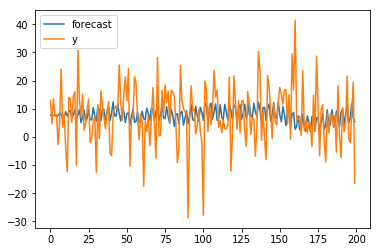

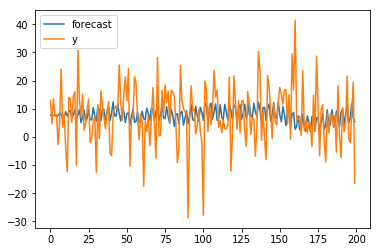

In [106]:
model_fit.plot_predict()

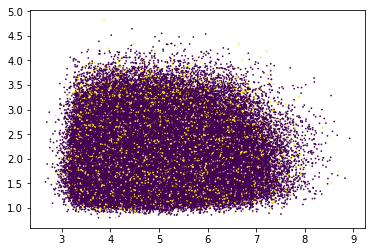

In [307]:
plt.scatter(x=transformed_df['var_103'].values,y=transformed_df['var_71'].values,s=0.5,c=transformed_df['target'])

<h6> Since columns are bell-shaped, we have made assumption about Box-Cox transformation from initial data. So we generated new features from inverse Box-Cox tranformation of columns.

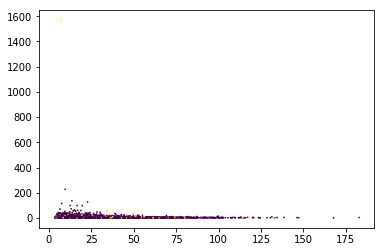

In [352]:
plt.scatter(x=a,y=b,s=0.5,c=transformed_df['target'])

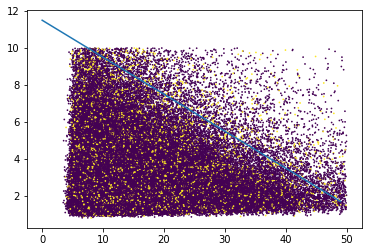

In [365]:
t = plt.scatter(tmp[(tmp['a']<50)&(tmp['b']<10)]['a'],tmp[(tmp['a']<50)&(tmp['b']<10)]['b'],
            c=tmp[(tmp['a']<50)&(tmp['b']<10)]['target'],s=0.5)
plt.plot([x for x in range(50)],[11.5 - x/5 for x in range(50)])

In [369]:
tmp[(tmp['a']<50)&(tmp['b']<10)&(tmp['a']/5 + tmp['b'] > 11.5)]['target'].value_counts(normalize=True)

0    0.877395
1    0.122605
Name: target, dtype: float64

In [356]:
tmp = pd.DataFrame()

In [357]:
tmp['a'] = a
tmp['b'] = b
tmp['target'] = transformed_df['target']

In [347]:
a = scipy.special.inv_boxcox(train_df['var_103'],-0.4)

In [348]:
b = scipy.special.inv_boxcox(train_df['var_71'],-0.63)

In [349]:
b.head(),len(b.dropna()),a.head(),len(a.dropna())

(0    2.014556
 1    1.859333
 2    3.392084
 3    1.312632
 4    2.888754
 Name: var_71, dtype: float64, 200000, 0     8.548555
 1    17.775453
 2     7.534465
 3     6.986167
 4    16.943862
 Name: var_103, dtype: float64, 200000)

In [324]:
a.describe()

count    200000.000000
mean          5.655536
std           1.260524
min           2.802835
25%           4.673415
50%           5.491159
75%           6.487024
max          11.824065
Name: var_103, dtype: float64

In [129]:
train_df.sort_index(inplace=True)

In [130]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [244]:
transformed_df = train_df[['ID_code','target']]

###### New features generation

In [291]:
for col in train_df.columns[2:]:
    transformed_df[col] = scipy.special.inv_boxcox(train_df[col],0)

In [294]:
transformed_df.describe().to_excel('describe_after_box_cox_inv_0.xlsx')

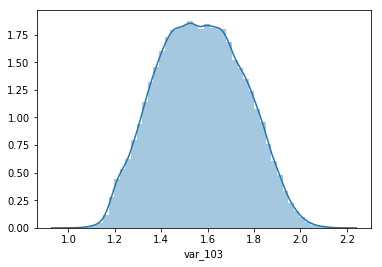

In [296]:
sns.distplot(train_df['var_103'])

In [ ]:
plt.scatter(x=tra['var_103'].values,y=transformed_df['var_71'].values,s=0.5,c=transformed_df['target'])

In [140]:
transformed_test = test_df[['ID_code']]

In [142]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [143]:
for col in test_df.columns[1:]:
    transformed_test[col] = scipy.special.inv_boxcox(test_df[col],0)

In [247]:
transformed_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177
count,200000.000000,200000.000000,153903.000000,200000.000000,200000.000000,200000.000000,1.013650e+05,200000.000000,200000.000000,1.884360e+05,...,1.999950e+05,200000.000000,171977.000000,1.532370e+05,1.999100e+05,149921.000000,200000.000000,200000.000000,1.224460e+05,200000.000000
mean,0.100490,428.497115,7.729234,400.468716,95.809085,379.149170,4.025369e+01,41.869413,1875.828745,8.941152e+00,...,6.815136e+01,44.081539,21.334562,2.866413e+01,7.350108e+03,40.837135,6042.426614,539.249276,5.471902e+01,550.208686
std,0.300653,425.740394,18.617061,347.662060,77.893290,185.618559,1.185813e+02,17.651227,1433.339224,1.541326e+01,...,1.056802e+02,7.630873,60.548678,7.191459e+01,1.155229e+04,97.452525,7114.825897,459.499808,1.353261e+02,411.970643
min,0.000000,1.480792,0.000000,5.843396,0.960441,33.214839,3.276800e-21,6.851550,38.000454,1.024000e-22,...,1.796960e-09,21.773262,0.000000,3.200000e-24,4.333630e-11,0.000000,0.010361,12.166938,3.200000e-24,31.240907
25%,0.000000,141.053181,0.030275,155.708464,36.277089,233.683431,7.778592e-02,28.451917,780.702335,1.007771e-01,...,8.680849e+00,38.459779,0.103245,9.198329e-02,7.399767e+02,0.151745,1040.644779,196.189420,1.343438e-01,227.893001
50%,0.000000,288.584536,0.760676,293.756338,73.987052,347.049789,2.190388e+00,38.654797,1455.374442,1.922545e+00,...,2.836464e+01,43.520564,2.223353,2.183281e+00,2.974186e+03,3.584784,3255.953942,413.146590,3.762604e+00,420.310746
75%,0.000000,565.125225,5.883944,527.729581,134.381473,490.337904,1.884954e+01,51.606635,2603.133691,1.105563e+01,...,8.029535e+01,49.358048,14.939360,1.933430e+01,9.030097e+03,29.941509,8643.320113,740.687683,3.367230e+01,778.130013
max,1.000000,3326.899157,275.093169,2741.020743,636.957598,1529.624459,1.745646e+03,140.731086,11949.346235,2.555050e+02,...,9.951718e+02,82.623172,1551.095251,2.022867e+03,2.209723e+05,2472.199383,86288.519966,3697.054830,3.281286e+03,3516.032685


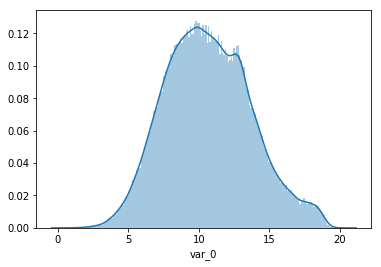

In [378]:
sns.distplot(train_df['var_0'],bins=200)